# Analysis of the attack: Adult No Targets
Analysis of the attack on Adult with the clustering made without considering the target variable. The black box model is the one created on the data generated with K = 6 for the clustering.
The data used for this attack are generated without the noisy validation dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../") 
import mlem

In [6]:
import warnings

Loading the bb and data (Clustering without target division, K=6, No noise in the dataset)

In [7]:
BLACK_BOX_PATH = './adult_no_target_division/K6/adult_randfor_k6.bz2'
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/risultati_no_cluster_on_targets/gaussian/same"
BLACK_BOX_DATA_PATH = './adult_no_target_division/K6/adult_randfor_k6_data.npz'
TRAIN_SET_CSV = 'adult_no_target_division/K6/train_k6.csv'
TEST_SET_CSV  = 'adult_no_target_division/K6/test_k6.csv'
CENTROIDS_NEIGHBORS = 'adult_no_target_division/K6/train_cluster_k6.csv'

In [8]:
def get_attack_mod(index:int, targets=[0,1], base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        
def get_local_model(index:int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Local model
    """
    path = f"{base_folder}/{index}/black_box"
    local_model_path = f"{path}/model.pkl.bz2"
    with bz2.BZ2File(local_model_path) as lm:
        local_model = pickle.load(lm)
    return local_model

def get_local_model_data(index: int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Structure with keys x and y
    """
    path = f"{base_folder}/{index}/black_box"
    data_path = f"{path}/data.npz"
    loaded = np.load(data_path, allow_pickle=True)
    return loaded

def get_subset_target_cluster(df, target, cluster):
    """
    Returns the subset of a dataframe with the specified target and cluster.
    """
    tmp = df[df['Target'] == target]
    return tmp[tmp['Cluster'] == cluster]

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

loading the data and the black box

In [9]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)

In [10]:
loaded = np.load(BLACK_BOX_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [11]:
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

doing some integrity checks

In [33]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]
adult_train = pd.read_csv(TRAIN_SET_CSV)
adult_test = pd.read_csv(TEST_SET_CSV)
adult_test_subset_cluster = pd.read_csv(CENTROIDS_NEIGHBORS)
assert (adult_train[feat_cols] == x_train).all().all() and \
       (adult_test[feat_cols] == x_test).all().all()   and \
       (adult_test_subset_cluster[feat_cols] == x_test_clustered).all().all()

In [9]:
adult_train_ones = adult_train[adult_train['Target'] == 1]
adult_train_zeroes = adult_train[adult_train['Target'] == 0]

In [10]:
adult_train_ones

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
1,7690,0.575597,0.218918,-0.405804,0.164328,-0.440434,0.455011,0.133907,0.493599,0.263855,0.113783,-0.147502,-0.218673,-0.078031,0.254411,1,0
6,1551,0.423288,0.218918,-0.422453,0.746667,2.306068,0.455011,0.448686,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,3
8,15076,0.880215,0.218918,0.888546,0.200180,-0.048076,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,1,0
10,6353,0.423288,0.218918,-0.351762,0.421658,1.128996,0.455011,0.133907,0.455728,0.263855,0.313955,0.271314,-0.218673,-0.078031,0.254411,1,3
22,26628,-0.033639,0.218918,-0.163331,0.421658,1.128996,0.455011,0.485342,0.455728,0.263855,0.313955,1.880305,-0.218673,0.756794,0.254411,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16858,29794,1.032523,0.285829,-0.041531,0.421658,1.128996,0.455011,0.485342,0.455728,0.263855,0.313955,-0.147502,-0.218673,0.756794,0.254411,1,3
16859,14064,-0.033639,0.218918,-0.195832,0.564576,1.521353,0.455011,0.485342,0.455728,0.263855,0.313955,-0.147502,-0.218673,1.591619,0.254411,1,3
16860,9349,-0.795183,0.218918,2.197415,0.421658,1.128996,0.455011,0.485342,0.493599,0.263855,0.113783,-0.147502,-0.218673,1.591619,0.254411,1,5
16861,26970,1.946377,0.285829,-0.815394,0.164328,-0.440434,0.455011,0.270647,0.455728,0.263855,0.313955,-0.147502,-0.218673,-2.165095,0.254411,1,0


In [11]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

Generating the classification reports and the confusion matrices.
This is the algorithm from my scheme
![schema attacco](./Images/schema.png)

ind=0 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/00_t0_c0
ind=1 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/01_t0_c0
ind=2 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/02_t0_c0
ind=3 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/03_t0_c0
ind=4 targ=0 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/04_t0_c0
ind=5 targ=1 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/05_t1_c0
ind=6 targ=1 clus=0 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/06_t1_c0
ind=7 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/07_t0_c1
ind=8 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/08_t0_c1
ind=9 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/09_t0_c1
ind=10 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING/10_t0_c1
ind=11 targ=0 clus=1 ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_O

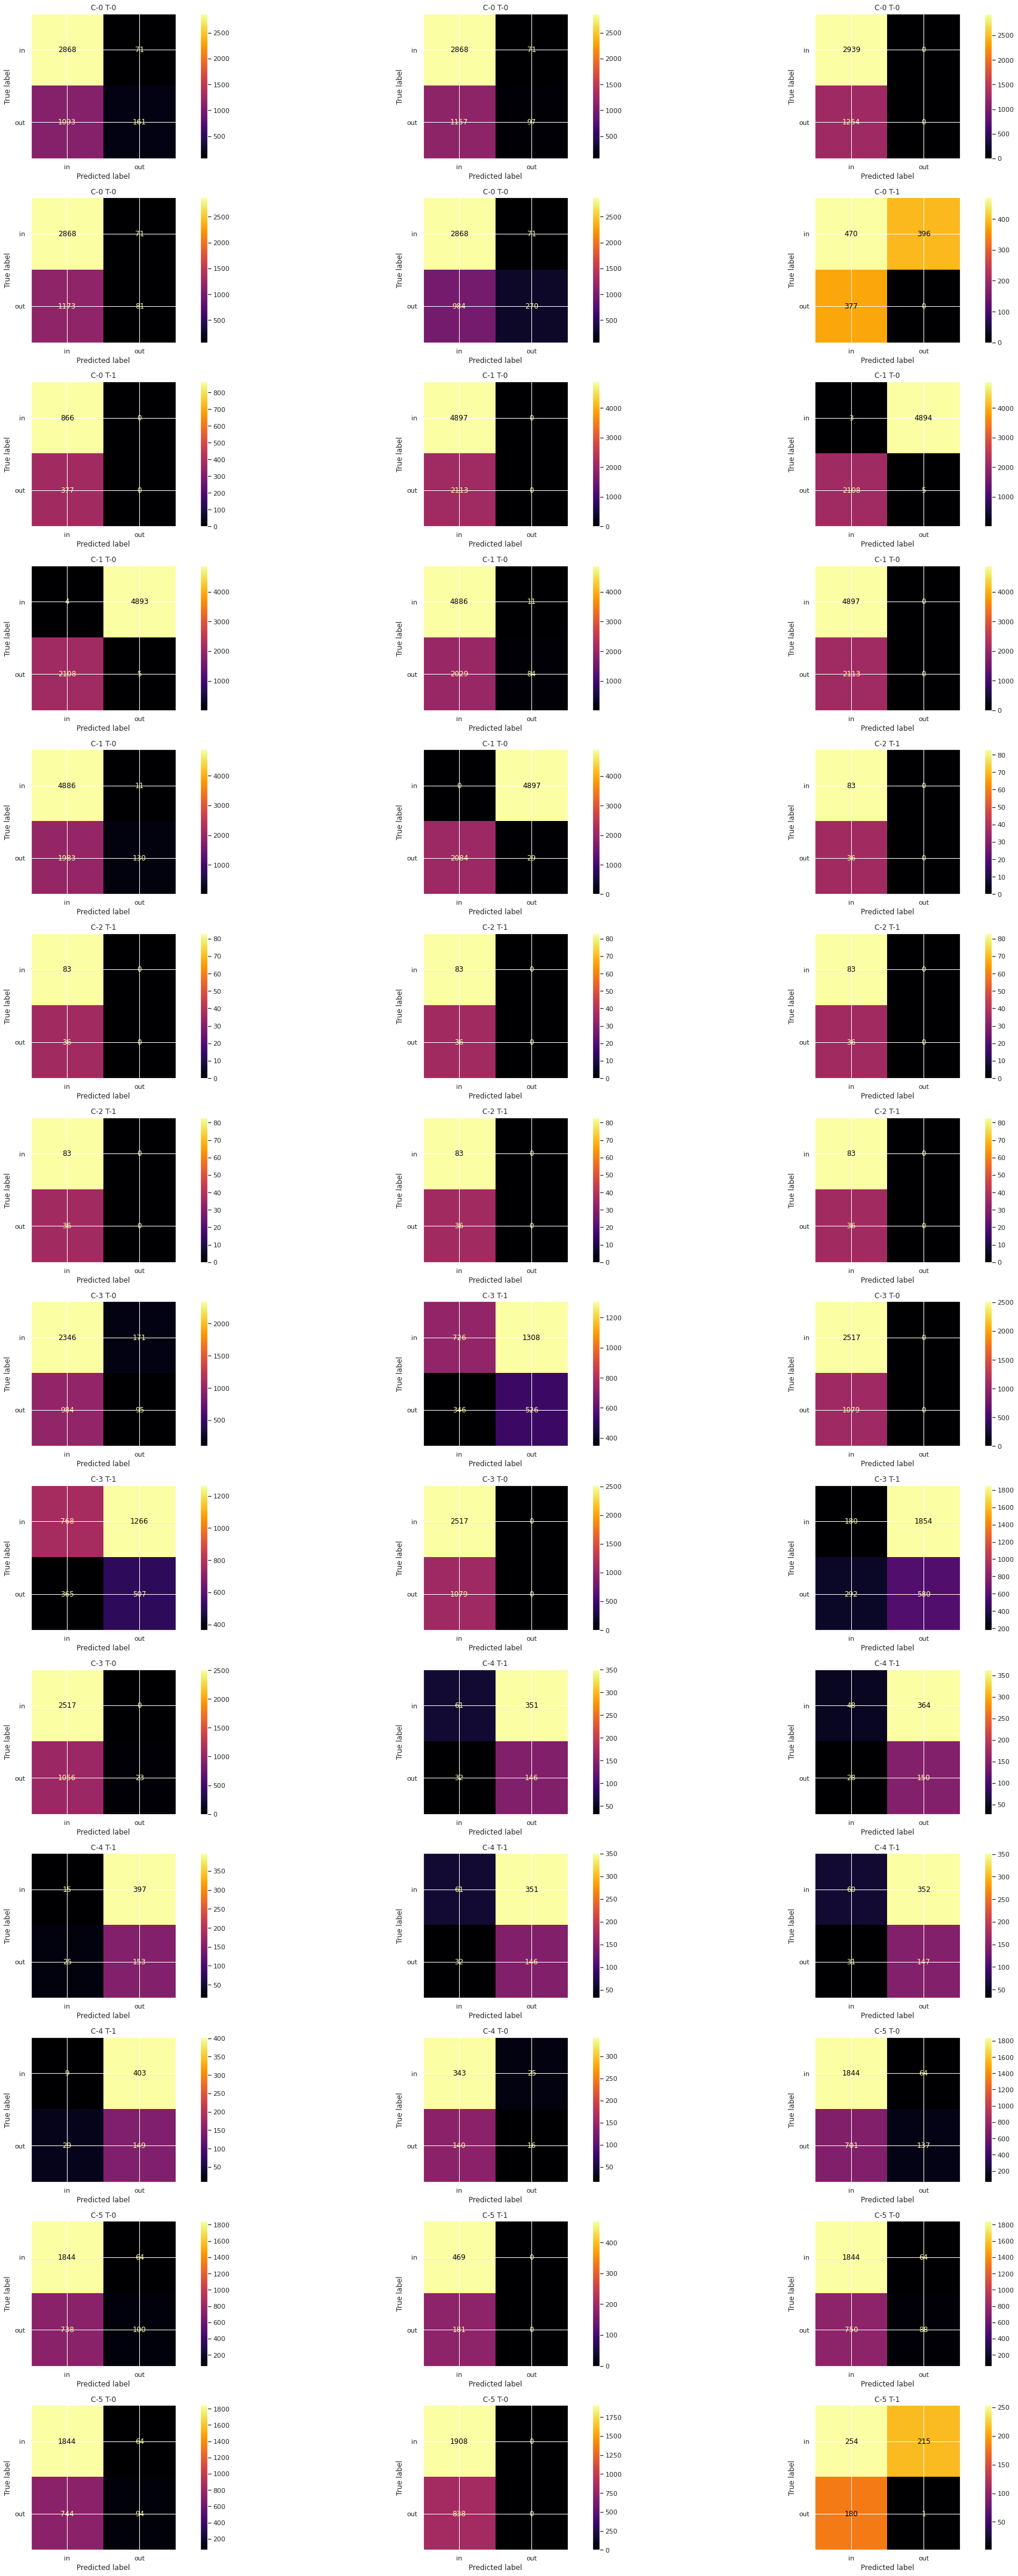

In [12]:
feat_cols = [
    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status',
    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss',
    'Hours-per-week', 'Native-country'
]

BASE_RESULTS_PATH = Path("ADULT_ANALYSIS_RESULTS_NO_TARGET_DIVISION_ON_CLUSTERING")
BASE_RESULTS_PATH.mkdir(exist_ok=False)

GLOBAL_RESULTS = []
fig, axs = plt.subplots(nrows=14, ncols=3, figsize=(30, 60))
axs_list = axs.ravel()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # for each (target, cluster)...
    for ind, (targ, clus) in enumerate(adult_test_subset_cluster[['Target', 'Cluster']].values):
        ind_res_path = BASE_RESULTS_PATH / f"{ind:02d}_t{targ}_c{clus}"
        ind_res_path.mkdir(exist_ok=True)
        print(f"{ind=} {targ=} {clus=} {ind_res_path}")
        # retrieve the attack models
        attack_0, attack_1 = get_attack_mod(ind)

        # TRAIN
        train_path = ind_res_path / "train"
        train_path.mkdir(exist_ok="true")
        # get the subset of the training set
        train_subset = get_subset_target_cluster(adult_train, targ, clus)

        probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
        
        ones_train, zeroes_train = split_probs_array(probs_train)
        
        assert len(zeroes_train) + len(ones_train) == len(probs_train)

        if len(zeroes_train) > 0:
            atk_0_train = attack_0.predict(zeroes_train)
            report_0_train = classification_report(["in"]*len(atk_0_train), atk_0_train)
            with open(str(train_path / "0.txt"), "w") as f:
                f.write(report_0_train)

        if len(ones_train) > 0:
            atk_1_train = attack_1.predict(ones_train)
            report_1_train = classification_report(["in"]*len(atk_1_train), atk_1_train)
            with open(str(train_path / "1.txt"), "w") as f:
                f.write(report_1_train)
        
        l0tr = len(zeroes_train)
        l1tr = len(ones_train)
        
        train_results = None
        if l0tr == 0:
            train_results = atk_1_train
        elif l1tr == 0:
            train_results = atk_0_train
        else:
            train_results = np.concatenate((atk_0_train, atk_1_train))
        with open(str(train_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["in"]*len(train_results), train_results)
            f.write(report_01_train)

        

        #TEST
        test_path = ind_res_path / "test"
        test_path.mkdir(exist_ok="true")
        # get test subset of the test set
        test_subset  = get_subset_target_cluster(adult_test, targ, clus)

        probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
        ones_test, zeroes_test = split_probs_array(probs_test)
        assert len(zeroes_test) + len(ones_test) == len(probs_test)

        if len(zeroes_test) > 0:
            atk_0_test = attack_0.predict(zeroes_test)
            report_0_test = classification_report(["out"] * len(atk_0_test), atk_0_test)
            with open(str(test_path / "0.txt"), "w") as f:
                f.write(report_0_test)

        if len(ones_test) > 0:
            atk_1_test = attack_0.predict(ones_test)
            report_1_test = classification_report(["out"] * len(atk_1_test), atk_1_test)
            with open(str(test_path / "1.txt"), "w") as f:
                f.write(report_1_test)
        
        l0te = len(zeroes_test)
        l1te = len(ones_test)
        test_results = None
        if l0te == 0:
            test_results = atk_1_test
        elif l1te == 0:
            test_results = atk_0_test
        else:
            test_results = np.concatenate((atk_0_test, atk_1_test))
            
        with open(str(test_path / "01.txt"), "w") as f:
            report_01_train = classification_report(["out"]*len(test_results), test_results)
            f.write(report_01_train)
        
        # Concatenating test and train
        with open(str(ind_res_path / "traintest_full.txt"), "w") as f:
            full = np.concatenate((train_results, test_results))
            mask = ["in"] * len(train_results) + ["out"] * len(test_results)
            f.write(classification_report(mask, full))
            aa = axs_list[ind]
            ConfusionMatrixDisplay.from_predictions(mask, full, ax=aa, cmap='inferno')
            aa.set_title(f"C-{clus} T-{targ}")
            
plt.tight_layout()

# Using a Voting classifier

In [12]:
from sklearn.utils.validation import check_is_fitted

In [29]:
def hard_classify(predictionslist):
    def count(x):
        print(x)
        ins = [h for h in x if h == "in"]
        if len(ins) > np.ceil(len(x) / 2):
            return "in"
        else:
            return "out"
    arr = np.asarray(predictionslist)
    print(arr)
    return np.apply_along_axis(count, axis=0, arr=arr)

In [30]:

hard_classify([["in", "in", "out"], ["in", "out", "out"], ["out", "out", "in"]])

[['in' 'in' 'out']
 ['in' 'out' 'out']
 ['out' 'out' 'in']]
['in' 'in' 'out']
['in' 'out' 'out']
['out' 'out' 'in']


array(['out', 'out', 'out'], dtype='<U3')

In [17]:
BASE_VOTING_PATH = Path(EXPERIMENTS_RESULTS_FOLDER) / "HARD_VOTING"
BASE_VOTING_PATH.mkdir(exist_ok=False)

In [26]:
np.ceil(3/2)

2.0

## Hard Voting

In [38]:
for a in adult_test_subset_cluster.groupby(['Cluster', 'Target']):
    # a[0] (cluster number, target variable)
    cluster_number, target_value = a[0]
    print(a[1]['Cluster'])
    ind = a[1].index.values.tolist() # used to retrieve the attack models

(0, 0)
0    0
1    0
2    0
3    0
4    0
Name: Cluster, dtype: int64
[0, 1, 2, 3, 4]
(0, 1)
5    0
6    0
Name: Cluster, dtype: int64
[5, 6]
(1, 0)
7     1
8     1
9     1
10    1
11    1
12    1
13    1
Name: Cluster, dtype: int64
[7, 8, 9, 10, 11, 12, 13]
(2, 1)
14    2
15    2
16    2
17    2
18    2
19    2
20    2
Name: Cluster, dtype: int64
[14, 15, 16, 17, 18, 19, 20]
(3, 0)
21    3
23    3
25    3
27    3
Name: Cluster, dtype: int64
[21, 23, 25, 27]
(3, 1)
22    3
24    3
26    3
Name: Cluster, dtype: int64
[22, 24, 26]
(4, 0)
34    4
Name: Cluster, dtype: int64
[34]
(4, 1)
28    4
29    4
30    4
31    4
32    4
33    4
Name: Cluster, dtype: int64
[28, 29, 30, 31, 32, 33]
(5, 0)
35    5
36    5
38    5
39    5
40    5
Name: Cluster, dtype: int64
[35, 36, 38, 39, 40]
(5, 1)
37    5
41    5
Name: Cluster, dtype: int64
[37, 41]


In [17]:
for a in adult_test_subset_cluster[['Target', 'Cluster']].groupby(['Target', 'Cluster']):
    indices = a[1].index.values.tolist()
    t,c = a[0][0], a[0][1]
    print(f"{t=} {c=} {indices=}")
    atk0 = []
    atk1 = []
    for ind in indices:
        a0, a1 = get_attack_mod(ind)
        atk0.append(a0)
        atk1.append(a1)
    
    
    train_subset = get_subset_target_cluster(adult_train, t, c)
    test_subset  = get_subset_target_cluster(adult_test, t, c)
    
    probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
    probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
    
    ones_train, zeroes_train = split_probs_array(probs_train)
    ones_test, zeroes_test = split_probs_array(probs_test)
    
    
    atk_0_train, atk_1_train, atk_0_test, atk_1_test = [], [], [], []
    if len(zeroes_train) > 0:
        atk_0_train = hard_classify([model.predict(zeroes_train) for model in atk0])

    if len(ones_train) > 0:
        atk_1_train = hard_classify([model.predict(ones_train) for model in atk1])
    
    if len(zeroes_test) > 0:
        atk_0_test = hard_classify([model.predict(zeroes_test) for model in atk0])

    if len(ones_test) > 0:
        atk_1_test = hard_classify([model.predict(ones_test) for model in atk1])
    
    print(f"{len(atk_0_train)=} {len(atk_1_train)=}")
    train_results = np.concatenate((atk_0_train, atk_1_train))
    train_labels  = ["in"] * len(train_results)
    test_results  = np.concatenate((atk_0_test, atk_1_test))
    test_labels   = ["out"] * len(test_results)
    
    full_results  = np.concatenate((train_results, test_results))
    full_labels   = np.concatenate((train_labels, test_labels))
    
    report_full = classification_report(full_labels, full_results)
    
    with open(str(BASE_VOTING_PATH / f"t{t}_c{c}.txt"), "w") as f:
        f.write(report_full)

t=0 c=0 indices=[0, 1, 2, 3, 4]
len(atk_0_train)=2 len(atk_1_train)=4126
t=0 c=1 indices=[5, 6, 7, 8, 9]
len(atk_0_train)=421 len(atk_1_train)=2949
t=0 c=2 indices=[10, 11, 12, 13, 14]
len(atk_0_train)=81 len(atk_1_train)=2752
t=0 c=3 indices=[15, 16, 17, 18, 19]
len(atk_0_train)=50 len(atk_1_train)=1925
t=0 c=4 indices=[20, 21, 22, 23, 24]
len(atk_0_train)=32 len(atk_1_train)=336
t=1 c=0 indices=[25, 26, 27, 28, 29]


/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

len(atk_0_train)=363 len(atk_1_train)=48
t=1 c=1 indices=[30, 31, 32, 33, 34]
len(atk_0_train)=721 len(atk_1_train)=1062
t=1 c=2 indices=[35, 36, 37, 38, 39]
len(atk_0_train)=83 len(atk_1_train)=0
t=1 c=3 indices=[40, 41, 42, 43, 44]


/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/3.9.9/envs/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

len(atk_0_train)=1602 len(atk_1_train)=323


In [47]:
class HardVotingClassifier:
    def __init__(classifiers: List):
        self.class = classifiers
        self.nclass = len(classifiers)
    def predict(x):
        

SyntaxError: invalid syntax (2427915421.py, line 3)

In [40]:
t, c = 0,0
train_subset = get_subset_target_cluster(adult_train, t, c)
test_subset  = get_subset_target_cluster(adult_test, t, c)
    
probs_train = black_box.predict_proba(train_subset[feat_cols].to_numpy())
probs_test = black_box.predict_proba(test_subset[feat_cols].to_numpy())
    
ones_train, zeroes_train = split_probs_array(probs_train)
ones_test, zeroes_test = split_probs_array(probs_test)

In [41]:
ones_train

array([[0.96527117, 0.03472883],
       [0.90753811, 0.09246189],
       [0.99718672, 0.00281328],
       ...,
       [0.99532263, 0.00467737],
       [0.86821866, 0.13178134],
       [0.92898825, 0.07101175]])

In [43]:
A0, A1 = get_attack_mod(0)

In [45]:
A0.predict(ones_train)

array(['in', 'in', 'in', ..., 'in', 'in', 'in'], dtype=object)

In [46]:
A1.predict(ones_test)

array(['in', 'in', 'in', ..., 'in', 'in', 'in'], dtype=object)

In [60]:
adult_train

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
0,17293,-0.566720,0.218918,-0.599990,0.164328,-0.440434,0.048399,0.116515,0.106689,0.129972,0.113783,-0.147502,-0.218673,1.591619,0.254411,0,3
1,7690,0.575597,0.218918,-0.405804,0.164328,-0.440434,0.455011,0.133907,0.493599,0.263855,0.113783,-0.147502,-0.218673,-0.078031,0.254411,1,0
2,14518,-1.328265,0.218918,-1.319214,0.164328,-0.440434,0.048399,0.116515,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,1
3,24055,0.270979,0.218918,1.017823,0.253968,0.736639,0.083784,0.485342,0.066334,0.277405,0.113783,-0.147502,-0.218673,-0.829374,0.117647,0,5
4,486,0.423288,0.285829,0.122065,0.564576,1.521353,0.455011,0.448686,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16872,24045,-0.795183,0.218918,0.806090,0.164328,-0.440434,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.244996,0.254411,0,5
16873,18727,-0.490566,0.268960,-0.191299,0.746667,2.306068,0.048399,0.448686,0.106689,0.263855,0.113783,-0.147502,-0.218673,2.426444,0.254411,0,3
16874,23398,0.118670,0.218918,-1.126609,0.253968,0.736639,0.048399,0.305159,0.106689,0.129972,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,3
16875,27490,-1.632883,0.218918,-0.505713,0.071951,-1.617506,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-1.747682,0.254411,0,1


In [62]:
adult_train[adult_train.columns[2]]

0        0.218918
1        0.218918
2        0.218918
3        0.218918
4        0.285829
           ...   
16872    0.218918
16873    0.268960
16874    0.218918
16875    0.218918
16876    0.218918
Name: Workclass, Length: 16877, dtype: float64

In [90]:
from typing import Callable
from numpy import array
def frequency_based_noise(column, size):
    """
    Sample values from a column with replacement.

    Args:
        column: column to sample from
        size: number of elements to sample

    Returns:
        Array of samples
    """
    return column.sample(size, replace=True).to_numpy()

def insert_noise_categorical(dataset: pd.DataFrame, perc: float = 0.1,
                             noise_generating_function: Callable[[pd.Series, int], array] = frequency_based_noise):
    """

    Args:
        dataset (DataFrame): dataset on which to insert the noise ( it should only contain categorical variables )
        perc (float): percentage of noise in the range [0,1]
       noise_generating_function (Callable[[int], array]): function used to generate the noise, must take as input the number of noisy values to
                                   generate inside an argument named size and return an array containing the random values.

    Returns:

    """
    n_rows, n_col = dataset.shape
    percentage = int(perc * n_rows)

    for c in range(n_col):
        index_to_replace = np.random.choice(dataset.index,
                                            size=percentage)
        new_values = noise_generating_function(dataset[dataset.columns[c]], size=percentage)
        assert (len(index_to_replace) == len(new_values))
        for ind, val in zip(index_to_replace, new_values):
            dataset.iloc[ind, c] = val

In [107]:
adult_train1 = adult_train.copy()

In [108]:
adult_train

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
0,17293,-0.566720,0.218918,-0.599990,0.164328,-0.440434,0.048399,0.116515,0.106689,0.129972,0.113783,-0.147502,-0.218673,1.591619,0.254411,0,3
1,7690,0.575597,0.218918,-0.405804,0.164328,-0.440434,0.455011,0.133907,0.493599,0.263855,0.113783,-0.147502,-0.218673,-0.078031,0.254411,1,0
2,14518,-1.328265,0.218918,-1.319214,0.164328,-0.440434,0.048399,0.116515,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,1
3,24055,0.270979,0.218918,1.017823,0.253968,0.736639,0.083784,0.485342,0.066334,0.277405,0.113783,-0.147502,-0.218673,-0.829374,0.117647,0,5
4,486,0.423288,0.285829,0.122065,0.564576,1.521353,0.455011,0.448686,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16872,24045,-0.795183,0.218918,0.806090,0.164328,-0.440434,0.455011,0.225590,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.244996,0.254411,0,5
16873,18727,-0.490566,0.268960,-0.191299,0.746667,2.306068,0.048399,0.448686,0.106689,0.263855,0.113783,-0.147502,-0.218673,2.426444,0.254411,0,3
16874,23398,0.118670,0.218918,-1.126609,0.253968,0.736639,0.048399,0.305159,0.106689,0.129972,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0,3
16875,27490,-1.632883,0.218918,-0.505713,0.071951,-1.617506,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-1.747682,0.254411,0,1


In [109]:
NUMERICAL_FEATURES = ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
CATEGORICAL_FEATURES = list(set(adult_train.columns[1:-2]) - set(NUMERICAL_FEATURES))

In [110]:
CATEGORICAL_FEATURES

['Relationship',
 'Native-country',
 'Workclass',
 'Sex',
 'Marital-status',
 'Education',
 'Occupation',
 'Race']

In [111]:
adult_train1[CATEGORICAL_FEATURES] = insert_noise_categorical(adult_train1[CATEGORICAL_FEATURES].copy())

In [106]:
any(adult_train1['Workclass'] == adult_train['Workclass'])

False

In [113]:
adult_train['Workclass']

0        0.218918
1        0.218918
2        0.218918
3        0.218918
4        0.285829
           ...   
16872    0.218918
16873    0.268960
16874    0.218918
16875    0.218918
16876    0.218918
Name: Workclass, Length: 16877, dtype: float64

In [114]:
adult_train1['Workclass']

0        None
1        None
2        None
3        None
4        None
         ... 
16872    None
16873    None
16874    None
16875    None
16876    None
Name: Workclass, Length: 16877, dtype: object

In [115]:
adult_train1

,Unnamed: 0,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Target,Cluster
0,17293,-0.566720,None,-0.599990,None,-0.440434,None,None,None,None,None,-0.147502,-0.218673,1.591619,None,0,3
1,7690,0.575597,None,-0.405804,None,-0.440434,None,None,None,None,None,-0.147502,-0.218673,-0.078031,None,1,0
2,14518,-1.328265,None,-1.319214,None,-0.440434,None,None,None,None,None,-0.147502,-0.218673,-0.078031,None,0,1
3,24055,0.270979,None,1.017823,None,0.736639,None,None,None,None,None,-0.147502,-0.218673,-0.829374,None,0,5
4,486,0.423288,None,0.122065,None,1.521353,None,None,None,None,None,-0.147502,-0.218673,-0.078031,None,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16872,24045,-0.795183,None,0.806090,None,-0.440434,None,None,None,None,None,-0.147502,-0.218673,-0.244996,None,0,5
16873,18727,-0.490566,None,-0.191299,None,2.306068,None,None,None,None,None,-0.147502,-0.218673,2.426444,None,0,3
16874,23398,0.118670,None,-1.126609,None,0.736639,None,None,None,None,None,-0.147502,-0.218673,-0.078031,None,0,3
16875,27490,-1.632883,None,-0.505713,None,-1.617506,None,None,None,None,None,-0.147502,-0.218673,-1.747682,None,0,1
